In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import os.path
import random as pyr
import sys
import tarfile
import argparse
import re
import simplejson
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import matplotlib as mpl
import pprint
import tarfile
import time
import io
pp = pprint.PrettyPrinter(indent=4)
def jsp(x): print(simplejson.dumps(x, indent=4, sort_keys=True))
import webloader as wl
from webloader import tarrecords, filters
from IPython.display import display

# train2014

In [3]:
with open("annotations/instances_train2014.json") as stream:
    instances = simplejson.load(stream)
with open("annotations/captions_train2014.json") as stream:
    captions = simplejson.load(stream)
with open("annotations/COCO_Text.json") as stream:
    cocotext = simplejson.load(stream)
with open("annotations/person_keypoints_train2014.json") as stream:
    person = simplejson.load(stream)

In [4]:
instances["images"][0]

{'license': 5,
 'file_name': 'COCO_train2014_000000057870.jpg',
 'coco_url': 'http://mscoco.org/images/57870',
 'height': 480,
 'width': 640,
 'date_captured': '2013-11-14 16:28:13',
 'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg',
 'id': 57870}

In [5]:
cocotext.keys()

dict_keys(['imgs', 'imgToAnns', 'cats', 'anns', 'info'])

In [6]:
all_images = {}
for x in instances["images"]:
    all_images[x["id"]] = dict(__key__=x["id"], info=x, image=x["file_name"], instances=None, captions=None, texts=None, persons=None)
def dappend(k, x):
    global all_images
    entry = all_images[x["image_id"]]
    if entry.get(k) is None: entry[k] = []
    entry[k].append(x)
for x in instances["annotations"]:
    dappend("instances", x)
for x in captions["annotations"]:
    dappend("captions", x)
for x in person["annotations"]:
    dappend("persons", x)
for _, x in cocotext["anns"].items():
    dappend("texts", x)


In [7]:
def stats(l): return (len(l), amin(l), median(l), mean(l), amax(l))

In [8]:
print(stats([len(x["instances"]) for x in all_images.values() if x["instances"] is not None]))
print(stats([len(x["captions"]) for x in all_images.values() if x["captions"] is not None]))
print(stats([len(x["persons"]) for x in all_images.values() if x["persons"] is not None]))
print(stats([len(x["texts"]) for x in all_images.values() if x["texts"] is not None]))

(82081, 1, 4.0, 7.369634872869483, 93)
(82783, 5, 5.0, 5.0023917954169335, 7)
(45174, 1, 2.0, 4.102271217957232, 20)
(26847, 1, 3.0, 5.433083770998622, 211)


In [9]:
if isinstance(all_images, dict):
    all_images = sorted(list(all_images.items()))
all_images = [x[1] for x in all_images]
all_images[0]

{'__key__': 9,
 'info': {'license': 3,
  'file_name': 'COCO_train2014_000000000009.jpg',
  'coco_url': 'http://mscoco.org/images/9',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-19 20:40:11',
  'flickr_url': 'http://farm5.staticflickr.com/4026/4622125393_84c1fdb8d6_z.jpg',
  'id': 9},
 'image': 'COCO_train2014_000000000009.jpg',
 'instances': [{'segmentation': [[500.49,
     473.53,
     599.73,
     419.6,
     612.67,
     375.37,
     608.36,
     354.88,
     528.54,
     269.66,
     457.35,
     201.71,
     420.67,
     187.69,
     389.39,
     192.0,
     19.42,
     360.27,
     1.08,
     389.39,
     2.16,
     427.15,
     20.49,
     473.53]],
   'area': 120057.13925,
   'iscrowd': 0,
   'image_id': 9,
   'bbox': [1.08, 187.69, 611.59, 285.84],
   'category_id': 51,
   'id': 1038967},
  {'segmentation': [[357.03,
     69.03,
     311.73,
     15.1,
     550.11,
     4.31,
     631.01,
     62.56,
     629.93,
     88.45,
     595.42,
     185.53,
     513.

In [10]:
def myimread(fname):
    with open("train2014/"+fname, "rb") as stream:
        return stream.read()
def cvjson(data):
    return bytes(simplejson.dumps(data, indent=4), encoding="utf-8")

names = {
    "info.json": "info",
    "jpg": "image",
    "persons.json": "persons",
    "instances.json": "instances",
    "texts.json": "texts",
    "captions.json": "captions"
}

In [11]:
!rm -rf coco-*.tar
print(len(all_images))
tarf = tarrecords.ShardWriter("coco-%06d.tar", encode=False, maxcount=5000, maxsize=3e9)
pipeline = filters.compose(
    filters.map(__key__=lambda x: "{:06d}".format(x),
                image=myimread,
                info=cvjson,
                persons=cvjson,
                instances=cvjson,
                texts=cvjson,
                captions=cvjson),
    filters.ren(names)
)
for v in pipeline(all_images):
    tarf.write(v)
tarf.close()

82783
# writing coco-000000.tar 0 0.0 GB 0
# writing coco-000001.tar 5000 0.9 GB 5000
# writing coco-000002.tar 5000 0.9 GB 10000
# writing coco-000003.tar 5000 0.9 GB 15000
# writing coco-000004.tar 5000 0.9 GB 20000
# writing coco-000005.tar 5000 0.9 GB 25000
# writing coco-000006.tar 5000 0.9 GB 30000
# writing coco-000007.tar 5000 0.9 GB 35000
# writing coco-000008.tar 5000 0.9 GB 40000
# writing coco-000009.tar 5000 0.9 GB 45000
# writing coco-000010.tar 5000 0.9 GB 50000
# writing coco-000011.tar 5000 0.9 GB 55000
# writing coco-000012.tar 5000 0.9 GB 60000
# writing coco-000013.tar 5000 0.9 GB 65000
# writing coco-000014.tar 5000 0.9 GB 70000
# writing coco-000015.tar 5000 0.9 GB 75000
# writing coco-000016.tar 5000 0.9 GB 80000


dict_keys(['__key__', 'info', 'image', 'instances', 'captions', 'texts', 'persons'])


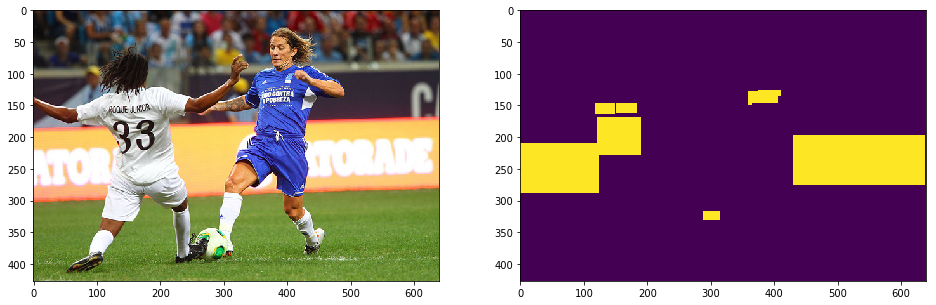

In [12]:
figsize(16,8)
l = list(all_images)
pyr.shuffle(l)
for v in l:
    k = v["__key__"]
    if v["texts"] is None: continue
    print(v.keys())
    image = imread("train2014/"+v["image"])
    h, w = image.shape[:2]
    textmap = zeros((h, w), 'f')
    for l in v["texts"]:
        x, y, w, h = [int(r) for r in l["bbox"]]
        textmap[y:y+h, x:x+w] = 1.0
    subplot(121); imshow(image)
    subplot(122); imshow(textmap)
    break

In [13]:
!rm -rf cocotexts-*.tar
text_images = [x for x in all_images if x.get("texts") is not None]
print(len(all_images), len(text_images))
tarf = tarrecords.ShardWriter("cocotexts-%06d.tar", encode=False, maxcount=5000, maxsize=3e9)
pipeline = filters.compose(
    filters.select(texts=lambda x: x is not None),
    filters.map(__key__=lambda x: "{:06d}".format(x),
                image=myimread,
                info=cvjson,
                persons=cvjson,
                instances=cvjson,
                texts=cvjson,
                captions=cvjson),
    filters.ren(names)
)
for v in pipeline(text_images):
    tarf.write(v)
tarf.close()

82783 26847
# writing cocotexts-000000.tar 0 0.0 GB 0
# writing cocotexts-000001.tar 5000 1.0 GB 5000
# writing cocotexts-000002.tar 5000 1.0 GB 10000
# writing cocotexts-000003.tar 5000 1.0 GB 15000
# writing cocotexts-000004.tar 5000 1.0 GB 20000
# writing cocotexts-000005.tar 5000 1.0 GB 25000


# val2014

In [14]:
with open("annotations/instances_val2014.json") as stream:
    instances = simplejson.load(stream)
with open("annotations/captions_val2014.json") as stream:
    captions = simplejson.load(stream)
with open("annotations/person_keypoints_val2014.json") as stream:
    person = simplejson.load(stream)

In [15]:
all_images = {}
for x in instances["images"]:
    all_images[x["id"]] = dict(__key__=x["id"], info=x, image=x["file_name"], instances=None, captions=None, texts=None, persons=None)
def dappend(k, x):
    global all_images
    entry = all_images[x["image_id"]]
    if entry.get(k) is None: entry[k] = []
    entry[k].append(x)
for x in instances["annotations"]:
    dappend("instances", x)
for x in captions["annotations"]:
    dappend("captions", x)
for x in person["annotations"]:
    dappend("persons", x)


In [16]:
print(stats([len(x["instances"]) for x in all_images.values() if x["instances"] is not None]))
print(stats([len(x["captions"]) for x in all_images.values() if x["captions"] is not None]))
print(stats([len(x["persons"]) for x in all_images.values() if x["persons"] is not None]))

(40137, 1, 4.0, 7.271968507860578, 70)
(40504, 5, 5.0, 5.003308315228126, 7)
(21634, 1, 2.0, 4.074743459369511, 16)


In [17]:
if isinstance(all_images, dict):
    all_images = sorted(list(all_images.items()))
all_images = [x[1] for x in all_images]
all_images[0]

{'__key__': 42,
 'info': {'license': 2,
  'file_name': 'COCO_val2014_000000000042.jpg',
  'coco_url': 'http://mscoco.org/images/42',
  'height': 478,
  'width': 640,
  'date_captured': '2013-11-18 09:22:23',
  'flickr_url': 'http://farm7.staticflickr.com/6024/6016274664_ea4ecac20c_z.jpg',
  'id': 42},
 'image': 'COCO_val2014_000000000042.jpg',
 'instances': [{'segmentation': [[382.48,
     268.63,
     330.24,
     229.93,
     278.97,
     205.75,
     228.66,
     143.83,
     214.15,
     140.93,
     225.76,
     134.16,
     257.69,
     123.52,
     277.03,
     82.89,
     328.3,
     48.06,
     433.75,
     41.29,
     502.43,
     79.99,
     561.44,
     168.02,
     547.9,
     216.39,
     562.41,
     246.38,
     542.09,
     285.07,
     510.17,
     285.07,
     467.61,
     223.16,
     419.24,
     253.15,
     394.09,
     264.76]],
   'area': 53481.5118,
   'iscrowd': 0,
   'image_id': 42,
   'bbox': [214.15, 41.29, 348.26, 243.78],
   'category_id': 18,
   'id': 1

In [21]:
!rm coco-val-*.tar
def myimread(fname):
    with open("val2014/"+fname, "rb") as stream:
        return stream.read()
print(len(all_images))
tarf = tarrecords.ShardWriter("coco-val-%06d.tar", encode=False, maxcount=5000, maxsize=3e9)
pipeline = filters.compose(
    filters.map(errors_are_fatal=True,
                __key__=lambda x: "{:06d}".format(x),
                image=myimread,
                info=cvjson,
                persons=cvjson,
                instances=cvjson,
                texts=cvjson,
                captions=cvjson),
    filters.ren(names)
)
for v in pipeline(all_images):
    tarf.write(v)
tarf.close()

40504
# writing coco-val-000000.tar 0 0.0 GB 0
# writing coco-val-000001.tar 5000 0.9 GB 5000
# writing coco-val-000002.tar 5000 0.9 GB 10000
# writing coco-val-000003.tar 5000 0.9 GB 15000
# writing coco-val-000004.tar 5000 0.9 GB 20000
# writing coco-val-000005.tar 5000 0.9 GB 25000
# writing coco-val-000006.tar 5000 0.9 GB 30000
# writing coco-val-000007.tar 5000 0.9 GB 35000
# writing coco-val-000008.tar 5000 0.9 GB 40000


In [22]:
!ls -lh *.tar

-rw-r--r-- 1 tmb tmb 800M Jul 16 23:53 coco-000000.tar
-rw-r--r-- 1 tmb tmb 792M Jul 16 23:54 coco-000001.tar
-rw-r--r-- 1 tmb tmb 793M Jul 16 23:55 coco-000002.tar
-rw-r--r-- 1 tmb tmb 789M Jul 16 23:56 coco-000003.tar
-rw-r--r-- 1 tmb tmb 793M Jul 16 23:57 coco-000004.tar
-rw-r--r-- 1 tmb tmb 787M Jul 16 23:57 coco-000005.tar
-rw-r--r-- 1 tmb tmb 791M Jul 16 23:58 coco-000006.tar
-rw-r--r-- 1 tmb tmb 788M Jul 16 23:59 coco-000007.tar
-rw-r--r-- 1 tmb tmb 799M Jul 17 00:00 coco-000008.tar
-rw-r--r-- 1 tmb tmb 794M Jul 17 00:01 coco-000009.tar
-rw-r--r-- 1 tmb tmb 782M Jul 17 00:02 coco-000010.tar
-rw-r--r-- 1 tmb tmb 791M Jul 17 00:03 coco-000011.tar
-rw-r--r-- 1 tmb tmb 798M Jul 17 00:03 coco-000012.tar
-rw-r--r-- 1 tmb tmb 791M Jul 17 00:04 coco-000013.tar
-rw-r--r-- 1 tmb tmb 794M Jul 17 00:05 coco-000014.tar
-rw-r--r-- 1 tmb tmb 793M Jul 17 00:06 coco-000015.tar
-rw-r--r-- 1 tmb tmb 440M Jul 17 00:06 coco-000016.tar
-rw-r--r-- 1 tmb tmb 796M Jul 17 00:38 coco-val-000000.tar
-rw-r-

In [23]:
!pwd

/mdata/coco-extract
